In [1]:
%matplotlib inline
import os, pickle, logging, pickle, joblib, sys, warnings
warnings.simplefilter('ignore')
from scipy import stats
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb

from sklearn import ensemble, metrics, pipeline, preprocessing, impute, model_selection
from scipy.stats import pearsonr

import shap

RAW_PATH = "/data2/zhoujb/project/cowpea_project/rawData/"
ML_RAW_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/rawData/"
FS_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/fs_PL/"
TEST_RES_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/ML/tesRes/"

In [2]:
feat_col_raw = []
with open(os.path.join(FS_PATH, "cb_rfa_cv_pl_rmse")) as f:
    for line in f:
        feat_col_raw.append(line.strip())

feat_col = []
feat_col_map = {}
for item in feat_col_raw:
    feat_col.append(item[4:])
    feat_col_map[item] = item[4:]


raw_data = pd.read_table(os.path.join(ML_RAW_PATH, "raw_data_PL.txt"), sep="\t", index_col=0)
raw_data = raw_data.rename(columns=feat_col_map)

target_col = ['HZ-PL']
raw_data = raw_data.dropna(subset=target_col)

kf = model_selection.KFold(n_splits=5, shuffle=True,  random_state=0)
y_test_final, y_pred_final = [], []
for i, (train_index, test_index) in enumerate(kf.split(raw_data)):
    data_train = raw_data.iloc[train_index].copy()
    data_test = raw_data.iloc[test_index].copy()

    scale_tool = preprocessing.StandardScaler()
    scale_tool.fit(data_train.loc[:, feat_col])
    data_train.loc[:, feat_col] = scale_tool.transform(data_train.loc[:, feat_col])
    data_test.loc[:, feat_col] = scale_tool.transform(data_test.loc[:, feat_col])

    train_sel = data_train.sample(frac=0.8, random_state=0)
    val_sel = data_train.drop(train_sel.index).copy()

    X_train = train_sel[feat_col].copy()
    y_train = train_sel[target_col].values.ravel()

    X_val = val_sel[feat_col].copy()
    y_val = val_sel[target_col].values.ravel()

    X_test = data_test[feat_col].copy()
    y_test = data_test[target_col].values.ravel()

    if i == 2:
        break

# Initialize CatBoostClassifier
clf_model = cb.CatBoostRegressor(random_state=0, thread_count=4, loss_function='RMSE')
# Fit model
clf_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, plot=False)

y_pred = clf_model.predict(X_test)

score_pear = pearsonr(y_test, y_pred)[0]
score_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
score_nrmse = score_rmse / np.std(y_test)

score_pear, score_rmse, score_nrmse

(0.9105320754173373, 8.157651982913361, 0.462204665375569)

In [3]:
data_scale = raw_data[feat_col].copy()
data_scale.loc[:, feat_col] = scale_tool.transform(data_scale.loc[:, feat_col])

explainer = shap.TreeExplainer(clf_model)
shap_values = explainer(data_scale[feat_col])

In [6]:
shap_val_df = pd.DataFrame(shap_values.values, columns=feat_col)
shap_feat_import = shap_val_df.abs().mean(0).sort_values(ascending=False).to_frame()
shap_feat_import.head(15)

,0
Chr09_35130001_35330000,3.228543
PSugar,1.956244
Chr04_46650001_46860000,1.812655
Chr03_58140001_58430000,1.352171
Chr03_7460001_7790000,1.245639
GNP,1.205731
Chr03_4330001_4500000,1.194239
Chr04_660001_840000,1.111546
Chr01_51400001_51530000,0.938119
Chr07_6770001_6920000,0.878021


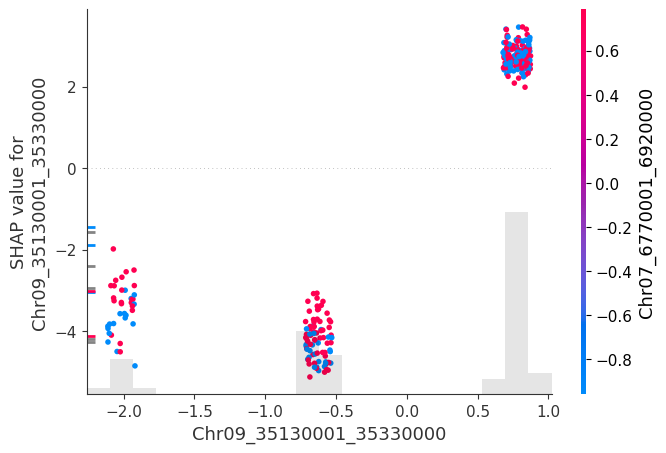

In [9]:
shap.plots.scatter(shap_values[:, "Chr09_35130001_35330000"], color=shap_values[:, "Chr07_6770001_6920000"], show=False)

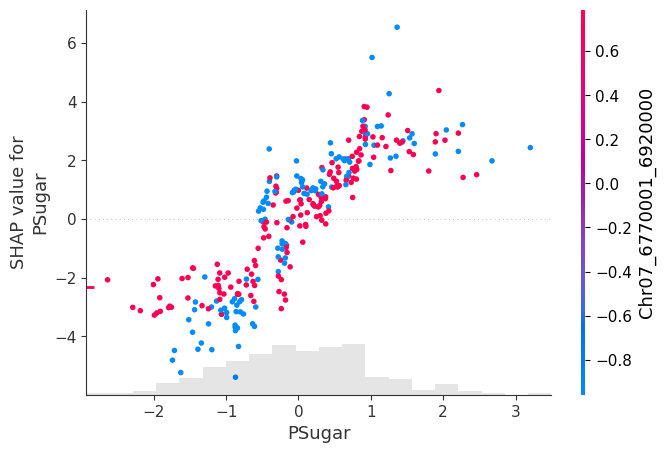

In [11]:
shap.plots.scatter(shap_values[:, "PSugar"], color=shap_values[:, "Chr07_6770001_6920000"], show=False)

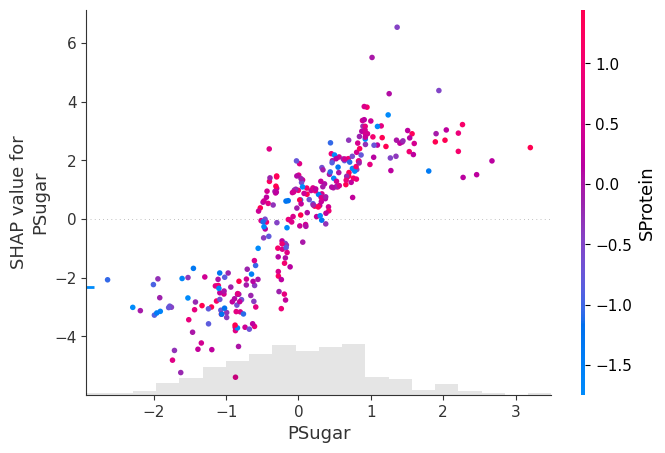

In [8]:
shap.plots.scatter(shap_values[:, "PSugar"], color=shap_values[:, "SProtein"], show=False)